In [213]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY, YearLocator, MonthLocator
from datetime import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared
# %matplotlib notebook
%matplotlib inline

In [214]:
# Functions for Bayesian Regression
def getPolynomialDataMatrix(x, degree):
    Xtilde = np.ones(x.shape)
    for i in range(1,degree + 1):
        Xtilde = np.column_stack((Xtilde, x ** i))
    return Xtilde

def getBetaForPolynomialFit(x, y, degree):
    Xtilde = getPolynomialDataMatrix(x, degree)
    XX = Xtilde.transpose().dot(Xtilde)
    regularizer = np.eye(XX.shape[0]) * 10 **-6
    betaTilde = np.linalg.solve(XX + regularizer, Xtilde.transpose().dot(y))
    return betaTilde

def getBayesianBetaForPolynomialFit(x, y, degree, sigma, regLambda):  # Gaussian Bayes rule 2
    # get polynomi
    Xtilde = getPolynomialDataMatrix(x, degree)
    XX = Xtilde.transpose().dot(Xtilde)
    regularizer = np.eye(XX.shape[0]) * regLambda * sigma
    betaTilde = np.linalg.solve(XX + regularizer, Xtilde.transpose().dot(y))
    sigmaBeta = sigma * np.linalg.inv(XX + regularizer)
    return betaTilde, sigmaBeta

In [215]:
df = pd.read_csv('/home/ash/Downloads/Historic COVID-19 Dashboard Data.csv')
# data = pd.read_csv('/home/ash/Downloads/Historic COVID-19 Dashboard Data.csv',
#                     usecols=['Date', 'Cases', 'Cumulative Cases'], )

df.head()
# data.head()

,Date,Cases,Cumulative Cases
0,31/01/2020,2,2
1,01/02/2020,0,2
2,02/02/2020,0,2
3,03/02/2020,0,2
4,04/02/2020,0,2


In [216]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df.set_index('Date', inplace=True)

In [233]:
def plotData(df, symbol, axisLocator='Year'):
    fig, ax = plt.subplots()
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
    dayFormatter = DateFormatter('%d')      # e.g., 12
    
    fig.subplots_adjust(bottom=0.2)
    
    if axisLocator == 'month':
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_major_formatter(weekFormatter)
        
    ax.plot(df[symbol])
    ax.scatter(df.index, df[symbol])
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
    return ax
#     plt.show()
    
    # ax.xaxis.set_minor_formatter(dayFormatter)
    # ax.xaxis.set_minor_locator(alldays)
    # ax.xaxis.set_major_locator(YearLocator())
    # ax.xaxis.set_major_locator(MonthLocator((1,2,3)))

    # ax.xaxis.set_major_formatter(DateFormatter("\n%m"))
    # ax.xaxis.set_minor_formatter(DateFormatter("%b"))

    # df[symbol].plot(ax=ax)
    
    # ax.plot(df['Cumulative Cases'])
    # ax.set_xticks(df.index)
    # ax.set_xticks(df['Date'])

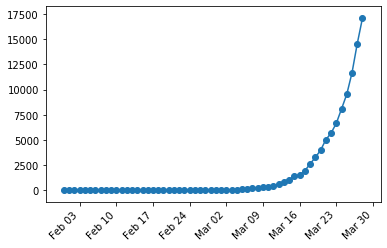

In [234]:
plotData(df, 'Cumulative Cases', axisLocator='month')  # axisLocator is either Year or month which comes on X axis

In [232]:
date_index = df.index.map(dt.toordinal)

In [283]:
# date_index.map(dt.fromordinal)
[2020-01-31].map(dt.toordinal)

SyntaxError: invalid token (<ipython-input-283-c4ed8460a835>, line 2)

In [221]:
# start_date, end_date = '2020-01-31', '2020-03-23'
# x_train = df.loc[start_date:end_date, ['Cumulative Cases']]

In [276]:
X_train, X_test, y_train, y_test = train_test_split(date_index, df['Cumulative Cases'],
                                                    test_size=0.8, random_state=3)
X_tran = X_train.to_numpy().reshape(-1, 1)
X_tet = X_test.to_numpy().reshape(-1, 1)
X_train.map(dt.fromordinal)

DatetimeIndex(['2020-03-21', '2020-03-12', '2020-03-14', '2020-02-10',
               '2020-02-19', '2020-02-21', '2020-01-31', '2020-02-08',
               '2020-02-03', '2020-02-24', '2020-03-13'],
              dtype='datetime64[ns]', name='Date', freq=None)

## Linear Regression

In [277]:
model_LR = LinearRegression() #create linear regression object
model_LR.fit(X_tran, y_train) #train model on train data
model_LR.score(X_tran, y_train) #check score
y_pred = model_LR.predict(date_index.to_numpy().reshape(-1, 1))
model_LR.coef_, model_LR.intercept_

(array([56.06584184]), -41346682.77539367)

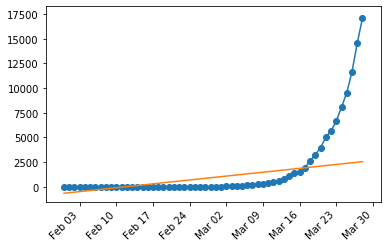

In [278]:
ax = plotData(df, 'Cumulative Cases', axisLocator='month') 
ax.plot(df.index, y_pred)

## Logistic Regression

/home/ash/Ash/venv3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


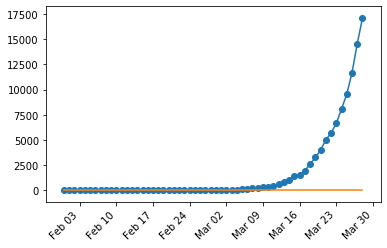

In [279]:
LR = LogisticRegression(C=0.1, solver='lbfgs').fit(X_tran, y_train)
y_pred = LR.predict(date_index.to_numpy().reshape(-1, 1))
ax = plotData(df, 'Cumulative Cases', axisLocator='month') 
ax.plot(df.index, y_pred)